### Deep Learning Supervised Text Classification
- BiLSTM (transformer-based data augmentation)

Bidirectional recurrent neural networks (RNN) put two independent RNNs together. This structure allows the networks to have both backward and forward information about the sequence at every time step


### Prepare Environment

In [ ]:
from numpy.random import seed
seed(156)
import tensorflow as tf
tf.random.set_seed(256)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/safety_report_tc

/content/drive/MyDrive/Colab_Notebooks/safety_report_tc


In [ ]:
# Importing required libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm.std import tqdm
from IPython.display import display, HTML
import time
import textwrap
import json
import datetime

### Load Data

In [ ]:
# Pick a minority category of interest (base data from source)
focus_cats = [
    'hydraulic fluid or oil leak',
    'line strike',
    'site compliance or practice issue',
    'ppe non-compliance_144_out_df_temp',
    'mechanical or equipment issue'
    ]

fns = [
    '2209031206', # hydraulic fluid or oil leak
    '2210031444', # line strike
    '2210031122', # site compliance or practice issue
    '2210031122', # ppe non-compliance
    '2210032046' # Mechanical or equipment issue
]

fn_aug_names = [
    'hydraulic fluid or oil leak_7920_trda',
    'line strike_',
    'site compliance or practice issue_8410_trda',
    'ppe non-compliance_',
    'mechanical or equipment issue_'
]

# Select a category to load
pick = input('Pick a category: ')
index = focus_cats.index(pick)
focus_cat = focus_cats[index]
fn = fns[index]
fn = f'01_data/prepared/{fn}_prepared_{focus_cat}_data.csv'

# Load data from a minority category of interest
df = pd.read_csv(fn)
df = df[['text', 'category']]
df = pd.read_csv(fn)
df

Pick a category: site compliance or practice issue


,text,category
0,foreign body entered employee l eye while grin...,0
1,drainage pipe damaged at two two m depth see s...,0
2,robodrill spider excavator being operated when...,0
3,pressure hose made contact with light fitting ...,0
4,nacap 30t hitachi hyd hose split resultong in ...,0
...,...,...
93852,fall on water vehicle an employee was using an...,0
93853,other fall to lower level unspecified an emplo...,0
93854,injured by slipping or swinging object held by...,0
93855,direct exposure to electricity greater than tw...,0


### Data Preparation (Train / Test Splits)

In [ ]:
# Now create the input to the model training stage
X = df.text
y = df.category # Remember, these are not necessarily the 'truth' but rule_book hits

# Apply a simple 80/20 split
# TODO - The dataset is heavily imbalanced. Treat this appropriately.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

In [ ]:
base_train_count = len(X_train)
base_train_count

75085

In [ ]:
test_trues = list(y_test[y_test==1].index.values)
test_trues.sort()
print('Test:', len(test_trues), test_trues)

train_trues = list(y_train[y_train==1].index.values)
train_trues.sort()
print('Train:', len(train_trues), train_trues)

Test: 59 [13, 38, 710, 925, 1071, 1143, 1323, 1440, 2382, 2610, 4545, 5033, 5620, 6845, 6937, 7708, 8034, 8309, 9228, 9378, 9650, 9785, 10478, 10552, 10651, 10698, 10806, 10979, 11008, 11186, 11704, 14130, 15616, 16266, 16305, 16644, 16659, 18158, 18280, 18441, 18504, 22527, 23763, 24005, 25447, 26450, 26559, 38153, 38876, 51290, 62644, 62691, 72009, 72447, 74225, 79333, 86509, 86652, 92972]
Train: 341 [20, 58, 168, 370, 372, 507, 585, 606, 664, 764, 844, 869, 881, 949, 979, 1007, 1243, 1350, 1584, 1604, 1754, 1804, 1816, 1825, 1903, 1936, 2081, 2088, 2143, 2190, 2226, 2320, 2338, 2381, 2388, 2522, 2559, 2713, 2808, 2935, 3236, 3262, 3332, 3480, 3564, 3785, 3820, 3892, 4316, 4349, 4560, 4597, 4608, 4718, 4739, 4956, 5075, 5142, 5172, 5173, 5295, 5344, 5359, 5467, 5517, 5704, 5743, 5785, 5801, 5862, 5977, 6105, 6186, 6340, 6352, 6367, 6457, 6463, 6742, 6840, 6886, 7056, 7111, 7228, 7477, 7483, 7597, 7598, 7721, 7726, 7770, 7781, 7792, 7845, 7872, 7980, 8031, 8232, 8305, 8332, 8398, 8432

In [ ]:
# Look at training 'trues', i.e., rule-book hits
df_train_trues = df.iloc[train_trues]
df_train_trues.to_csv('01_data/prepared/df_train_trues.csv')
df_train_trues

,text,category
20,approximately fifteen litres of sewage overflo...,1
58,worker observed without appropriate fall prote...,1
168,lifting coordinator lc preparing to perform a ...,1
370,tm crossed outer ndt exclusion zone barricade ...,1
372,unsafe act individual knowingly crossed a barr...,1
...,...,...
88783,other fall to lower level six to ten feet whil...,1
90941,other fall to lower level six to ten feet an e...,1
91446,other fall to lower level sixteen to twenty fe...,1
91534,other fall to lower level eleven to fifteen fe...,1


### Transformer Data Augmentation (TrDA)

In [ ]:
# Load fabricated reports
fn_name = fn_aug_names[index] 
df_fab = pd.read_csv(f'01_data/fabricated/{fn_name}.csv')
df_fab

,text,group
0,good practice not applied for investigation an...,site compliance or practice issue
1,good practice not applied,site compliance or practice issue
2,good practice not applied by law enforcement e...,site compliance or practice issue
3,good practice not applied see detailed descrip...,site compliance or practice issue
4,good practice not applied to contractors durin...,site compliance or practice issue
...,...,...
8405,failure to respect process or procedure as an ...,site compliance or practice issue
8406,failure to respect process or procedures or pe...,site compliance or practice issue
8407,failure to respect process or equipment incide...,site compliance or practice issue
8408,failure to respect process supervisor personne...,site compliance or practice issue


In [ ]:
# Prepare data by augmenting the raw (real) training data
X_train_fab = df_fab.text
X_train_new = X_train.append(X_train_fab)
X_train_list = list(X_train_new)
y_train_list = list(y_train)

df_tmp = pd.DataFrame(X_train_list, columns = ['text'])
y_train_list.extend([1 for i in range(len(X_train_fab))])
df_tmp['category'] = y_train_list
df_tmp

,text,category
0,ip operated air assisted door with left hand w...,0
1,twenty x spiders fell from roof when generator...,0
2,struck by discharged object or substance an em...,0
3,caught in running equipment or machinery n e c...,0
4,caught in running equipment or machinery durin...,0
...,...,...
83490,failure to respect process or procedure as an ...,1
83491,failure to respect process or procedures or pe...,1
83492,failure to respect process or equipment incide...,1
83493,failure to respect process supervisor personne...,1


In [ ]:
# Shuffle the dataframe
df_tmp = df_tmp.sample(frac=1).reset_index(drop=True)
df_tmp

,text,category
0,fall on same level due to tripping over an obj...,0
1,compressed or pinched by shifting objects or e...,0
2,ip tripped on curb and cut chin at 0700hrs on ...,0
3,crew did not respect process onboard an offsit...,1
4,ip requested to be flown back onshore to seek ...,0
...,...,...
83490,theft of generator third incident trespasser e...,0
83491,caught in running equipment or machinery unspe...,0
83492,employees reported gunshots being fired from o...,0
83493,compressed or pinched by shifting objects or e...,0


In [ ]:
# Quick visual check of a random sample of 20 (hits)
df_tmp[df_tmp['category']==1].sample(20)

,text,category
55169,ip did not observe good practice during client...,1
62996,she did not follow site practice while cleanin...,1
37727,right did not observe normal practice of enter...,1
45109,apprentice did not respect good practice pract...,1
51507,individual did not follow process with wood em...,1
15742,her did not apply procedure to be notified abo...,1
16055,failure to observe normal practice or procedur...,1
43836,dot violation noimproper breakaway or emergenc...,1
7937,operator did not observe procedure at time of ...,1
61452,lady did not respect permit process wood emplo...,1


## Build Model

In [ ]:
# Load modelling building libraries
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from collections import Counter
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging
logging.basicConfig(level=logging.INFO)

In [ ]:
# Create a function to prepare model input sequences and embedding dictionary
def prepare_model_input(X_train, X_test, MAX_NB_WORDS=75000, MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    all_text = np.concatenate((X_train, X_test), axis=0)
    all_text = np.array(all_text)

    # Fit tokeniser only on training text
    text = np.array(X_train)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)

    # Save the tokenizer as .pkl file
    pickle.dump(tokenizer, open(f'08_output/{time.strftime("%y%m%d%H%M")}_text_tokenizer.pkl', 'wb'))

    # Generate sequences for all text using tokenizer created only on training text
    # This converts the sentence into a sequence of integers, e.g., [2, 4, 5, 7]
    sequences = tokenizer.texts_to_sequences(all_text)

    # Get a list of all words and their sequence numbers
    word_index = tokenizer.word_index

    # Pad out the sequences with zeroes to max sequence length
    all_text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    
    # Seperate training sequences from test
    X_train_Glove = all_text[0:len(X_train), ]
    X_test_Glove = all_text[len(X_train):, ]

    # Now gather the embeddings
    # Start with standard GloVe
    ## https://www.google.com/search?client=safari&rls=en&q=glove+embeddings&ie=UTF-8&oe=UTF-8
    embeddings_dict = {}
    f = open("03_embeddings/glove/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)


In [ ]:
# Create a function that builds the deep learning model
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Initialize a sequential model
    model = Sequential()
    
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    print('_words', len(word_index))
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    # Default will be 3 layers
    # Default lstm nodel number will be 32
    for i in range(0, hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))

        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))

    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))

    # Attention addition
    #model.add(attention(return_sequences=True))
    
    model.add(Dropout(dropout))

    # Add the fully connected layer with 256 nuerons & Relu activation
    model.add(Dense(256, activation='relu'))

    # Add the output layer with softmax activation (binary output)
    model.add(Dense(nclasses, activation='softmax'))

    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=["categorical_accuracy"])
    return model

In [ ]:
X_train = df_tmp.text
y_train = df_tmp.category

print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train, X_test)
print("Done!")

Preparing model input ...
Total 400000 word vectors.
Done!


In [ ]:
print("Building Model!")
model = build_bilstm(word_index, embeddings_dict, 2)
model.summary()

Building Model!
_words 72463
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           3623200   
                                                                 
 bidirectional (Bidirectiona  (None, 500, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 500, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 500, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 500, 64)           0         
                                                                 
 bidirectional_2 (Bidirecti

In [ ]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1].iloc[0]

'fall through surface or existing opening more than thirty feet an employee was installing safety railings on a new parking deck construction when he tripped and fell through an elevator shaft to the ground below approximately fifty feet he suffered fractures to both legs two fractured ribs and a major spinal compression requiring hospitalization fall protection was not worn at the time of the incident'

### Model Training & Evaluatrion

In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "precision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }

def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


In [ ]:
# Quick view of rule_book hits (should represent the focus category)
X_test[y_test == 1]

79333    fall through surface or existing opening more ...
9650     subcontractor employee climbed over a handrail...
18504    worker observed working at height without usin...
23763    cp20210080 nmg fournier lsr breach working at ...
18441    skid steer with auger bit attachment drilled i...
86652    nonroadway incident involving motorized land v...
1143     while identifying issues to fix before sign of...
10478    employee working at height without a harness o...
16266    excavator operator swung into a swivel dump tr...
11008    extension cable plug burneddamaged worker plug...
9785     dot violation driver cited for being overweigh...
8034     unsecured section of metal floor grating fell ...
9378     near miss with lsr violation cut into isolated...
92972    other fall to lower level less than six feet a...
25447    minor property damage to fence post at wpc whi...
10552    working height without full body harness e i c...
38       tag line came disconnected from load rigger at.

In [ ]:
# Reminder of test set breakdown
Counter(y_test)

Counter({0: 18713, 1: 59})

In [ ]:
# Verify augmented training set breakdown
Counter(y_train)

Counter({0: 74744, 1: 8751})

In [ ]:
# Split training into training and validation data
X_train_vGlove, X_val_Glove, y_vtrain, y_val = train_test_split(X_train_Glove, y_train, test_size = 0.1, stratify=y_train, random_state = 1234)

# Verify stratification
num_pos_vTrain = len(y_vtrain[y_vtrain==1])
print(f'Number of positives in training (val) split: {num_pos_vTrain}')

num_pos_val = len(y_val[y_val==1])
print(f'Number of positives in validation data: {num_pos_val}')

Number of positives in training (val) split: 7876
Number of positives in validation data: 875


In [ ]:
# Train the model
print('Training for:', focus_cat)
epoch_num = int(input('Enter epoch number (default is 3): '))
history = model.fit(X_train_vGlove, y_vtrain,
                              validation_data=(X_val_Glove, y_val),
                              epochs=epoch_num,
                              batch_size=128,
                              verbose=1)

Training for: site compliance or practice issue
Epoch 1/3
588/588 [==============================] - 1733s 3s/step - loss: 0.0855 - categorical_accuracy: 0.9052 - val_loss: 0.0340 - val_categorical_accuracy: 0.8972
Epoch 2/3
588/588 [==============================] - 1726s 3s/step - loss: 0.0462 - categorical_accuracy: 0.9023 - val_loss: 0.0250 - val_categorical_accuracy: 0.9005
Epoch 3/3
588/588 [==============================] - 1724s 3s/step - loss: 0.0210 - categorical_accuracy: 0.8978 - val_loss: 0.0170 - val_categorical_accuracy: 0.8980


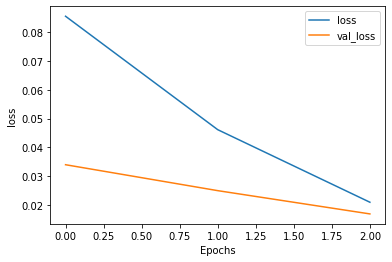

In [ ]:
# Plot training history
plot_graphs(history, 'loss')

In [ ]:
# Print accuracy measures
print("\n Evaluating Model ... \n")

predicted = model.predict(X_test_Glove)
predicted = np.argmax(predicted, axis=1)

print(metrics.classification_report(y_test, predicted))
print("\n")


 Evaluating Model ... 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18713
           1       0.35      0.27      0.30        59

    accuracy                           1.00     18772
   macro avg       0.67      0.63      0.65     18772
weighted avg       1.00      1.00      1.00     18772





In [ ]:
# Create dataframe for inspection of results
tmp = pd.DataFrame(X_test, columns=['text'])
tmp['pred'] = predicted
tmp['rule_book'] = y_test.values

# Quick look at predicted positives
print('Check rule-book hit count: ', len(tmp[tmp['rule_book']==1]))

Check rule-book hit count:  59


In [ ]:
# Examine precision stats
# Look at predicted positives that did not have a rule-book hit
table = tmp[(tmp['pred']==1) & (tmp['rule_book']==0)]
table.to_csv(f'10_performance/model_{focus}_bda_fps.csv')
display(HTML(table.to_html()))
total_pos_preds = len(tmp[(tmp['pred']==1)])
total_pos_hits = len(tmp[(tmp['pred']==1) & (tmp['rule_book']==1)])
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')
print(f'\nTotal no. of positive predictions is  {total_pos_preds}...')
print(f'\nTotal no. of positive hits is  {total_pos_hits }...')

NameError: ignored

In [ ]:
# Take a look at predicted negatives that had a rule-book hit
table = tmp[(tmp['pred']==0) & (tmp['rule_book']==1)]
display(HTML(table.to_html()))
print(f'\nThere are {len(table)} entries (out of {sum(y_test==1)})...')

In [ ]:
# Save the model
filename = f'08_output/models/{time.strftime("%y%m%d%H%M")}_{focus_cat}_bilstm_trda_{epoch_num}_model.pkl'
pickle.dump(model, open(filename, 'wb'))